# DIEGO LEMOS
# 20204787
## Forecasting Revenue Trends Using Time Series Analysis

# Online Retail Dataset

## Data Loading and Processing

In [315]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.ticker as mtick
from scipy.stats import f_oneway
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found.*")


In [ ]:
# Loading the datasets
# UCI Machine Learning Repository

df = pd.read_excel('/Users/diegolemos/Masters/ProgrammingForAi/final_project/Online Retail.xlsx')

# Printing dataframe head
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [317]:
# Getting the informations from the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [318]:
# Checking the number of features and observations
df.shape

(541909, 8)

#### Insight
As we can see there are 541909 observations and 8 features in the dataset.

In [319]:
# Checking for missing values
print(f'Missing values for online retail dataframe: \n{df.isnull().sum()}')

Missing values for online retail dataframe: 
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


#### Insight
As seen above, there are missing values in features as 'Description' and 'CustomerID', 'Description' will be valiable for the future analysis, thus, the observations with missing value will be dropped but the 'CustomerID' missing values will be replaced with a '0' value.

In [320]:
# Dropping missing values in 'Description'
df = df.dropna(subset = ['Description'])

# Replacing missing values in 'CustomerID'
df['CustomerID'] = df['CustomerID'].fillna(0)

In [321]:
# Checking missing values again
print(f'Missing values for online retail dataframe: \n{df.isnull().sum()}')

Missing values for online retail dataframe: 
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


#### Insight
The are no more missing values.

In [322]:
# Checking for duplicates.

df.duplicated().sum()

5268

In [323]:
# Printing duplicated rows
duplicates = df[df.duplicated()]
print(duplicates)

       InvoiceNo StockCode                        Description  Quantity  \
517       536409     21866        UNION JACK FLAG LUGGAGE TAG         1   
527       536409     22866      HAND WARMER SCOTTY DOG DESIGN         1   
537       536409     22900    SET 2 TEA TOWELS I LOVE LONDON          1   
539       536409     22111       SCOTTIE DOG HOT WATER BOTTLE         1   
555       536412     22327  ROUND SNACK BOXES SET OF 4 SKULLS         1   
...          ...       ...                                ...       ...   
541675    581538     22068        BLACK PIRATE TREASURE CHEST         1   
541689    581538     23318     BOX OF 6 MINI VINTAGE CRACKERS         1   
541692    581538     22992             REVOLVER WOODEN RULER          1   
541699    581538     22694                       WICKER STAR          1   
541701    581538     23343       JUMBO BAG VINTAGE CHRISTMAS          1   

               InvoiceDate  UnitPrice  CustomerID         Country  
517    2010-12-01 11:45:00     

In [324]:
# Droppin exact similar duplicates 
df = df.drop_duplicates()

# Checking remaning duplicates
print(f'Remaning duplicates: {df.duplicated().sum()}')

Remaning duplicates: 0


#### Insight
There was a few rows duplicated and it was dropped as it looked like to be the same entrance of data replicated.

In [325]:
# Checking for unique value
df.nunique()

InvoiceNo      24446
StockCode       3958
Description     4223
Quantity         671
InvoiceDate    22309
UnitPrice       1630
CustomerID      4373
Country           38
dtype: int64

In [326]:
# Separating negatives values that may represents returns
df_returns = df[df['Quantity'] < 0]

# Saving the return data to a file for future analysis
df_returns.to_csv('returns_data.csv', index = False)

# Removing returns from the main dtaaframe
df = df[df['Quantity'] >= 0]

In [327]:
# Filtering negatives 'UnitPrice'
df = df[df['UnitPrice'] > 0]


In [328]:
# Checking filted dataframe informations
print(f'Filted dataframe shape: {df.shape}')
df.head()

Filted dataframe shape: (524878, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


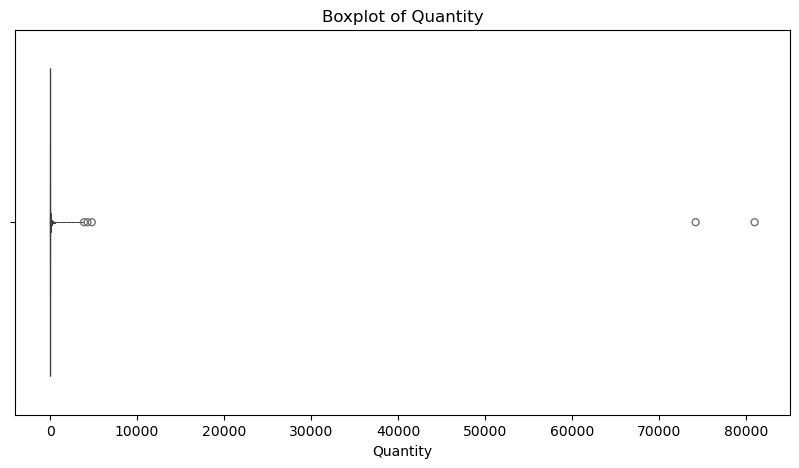

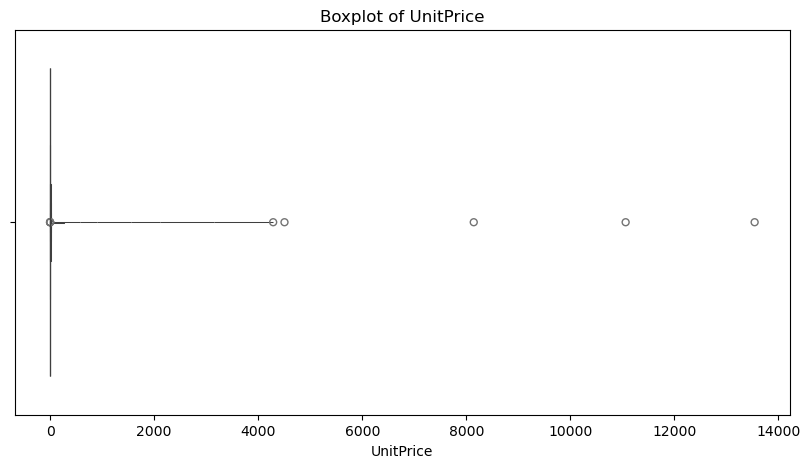

In [329]:
# Checking for outliers in the numeric columns using boxplot

# Boxplot for 'Quantiry' feature
plt.figure(figsize = (10, 5))
sns.boxenplot(x = df['Quantity'])
plt.title('Boxplot of Quantity')
plt.show() 

# Boxplot for 'UnitPrice' feature
plt.figure(figsize = (10, 5))
sns.boxenplot(x = df['UnitPrice'])
plt.title('Boxplot of UnitPrice')
plt.show()

In [330]:
# Applying the interquartile range system to selec and drop the outliers in column 'Quantity'

Q1= df['Quantity'].quantile(0.25)
Q3= df['Quantity'].quantile(0.75)
IQR = Q3-Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df_cleaned = df[(df['Quantity'] >= lower) & (df['Quantity'] <= upper)]

In [331]:
# Applying the interquartile range system to selec and drop the outliers in column 'UnitPrice'

Q1= df['UnitPrice'].quantile(0.25)
Q3= df['UnitPrice'].quantile(0.75)
IQR = Q3-Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df_cleaned = df[(df['UnitPrice'] >= lower) & (df['UnitPrice'] <= upper)]

In [332]:
# Cheking the number of features and observations of the cleaned dataset
df_cleaned.shape

(487051, 8)

In [333]:
# Checking for duplicates after cleaning
df.duplicated().sum()

0

#### Insight
While working on outliers, it was noted some negatives values in 'Quantity' and 'UnitPrice' features, so they were filtered from the dataframe, after that it was took in consideration that those negative values could represent returns made by customers, thus it was saved on a specific dataframe for possible future analysis.

After plotting the boxplot, it was detected outliers in 'Quantity' and 'UnitPrice' features. Thus, the interquartile range technique was applied to eliminate the outliers in those columns. This statistical technique consists of taking the difference between the third quartile and the first one from a group of data then it measures the central dispersion of the data, eliminating the outliers.

In [334]:
# Optimizing data types
df_cleaned = df_cleaned.copy()

df_cleaned['InvoiceNo'] = df_cleaned['InvoiceNo'].astype('category')
df_cleaned['StockCode'] = df_cleaned['StockCode'].astype('category')
df_cleaned['Description'] = df_cleaned['Description'].astype('category')
df_cleaned['Country'] = df_cleaned['Country'].astype('category')
df_cleaned['CustomerID'] = df_cleaned['CustomerID'].astype('int64')


#### Insight
The data type optimization was made to reduce memory usage during the analysis peformance.

In [335]:
# Creating additional temporal features for further analysis
df_cleaned['Year'] = df_cleaned['InvoiceDate'].dt.year
df_cleaned['Month'] = df_cleaned['InvoiceDate'].dt.month
df_cleaned['Day'] = df_cleaned['InvoiceDate'].dt.day
df_cleaned['Hour'] = df_cleaned['InvoiceDate'].dt.hour
df_cleaned['Weekday'] = df_cleaned['InvoiceDate'].dt.weekday #0 = Monday - 6 = Sunday

In [336]:
# Checking for missing values in temporal features
print(df_cleaned[['Year', 'Month', 'Day', 'Hour', 'Weekday']].isnull().sum())

Year       0
Month      0
Day        0
Hour       0
Weekday    0
dtype: int64


In [337]:
# Checking the ranges of temporal features
print(f'Year range: {df_cleaned['Year'].min()} - {df_cleaned['Year'].max()}')
print(f'Month range: {df_cleaned['Month'].min()} - {df_cleaned['Month'].max()}')
print(f'Day range: {df_cleaned['Day'].min()} - {df_cleaned['Day'].max()}')
print(f'Hour range: {df_cleaned['Hour'].min()} - {df_cleaned['Hour'].max()}')
print(f'Weekday range: {df_cleaned['Weekday'].min()} - {df_cleaned['Weekday'].max()}')

Year range: 2010 - 2011
Month range: 1 - 12
Day range: 1 - 31
Hour range: 6 - 20
Weekday range: 0 - 6


#### Insight
As it is showed above, the temporal features were successfuly extrated from the 'InvoiceData' column.

In [338]:
# Creating revenue column for further analysis
df_cleaned['Revenue'] = df_cleaned['Quantity'] * df_cleaned['UnitPrice']

In [339]:
# Checking for zero or missing values in 'Revenue'
print(f'Missing values in Revenue: {df_cleaned['Revenue'].isnull().sum()}')
print(f'Zero values in Revenue: {(df_cleaned['Revenue'] == 0).sum()}')


Missing values in Revenue: 0
Zero values in Revenue: 0


#### Insight 
After verification, it is noted that there is no missing or zero values, this ensure that the column 'Revenue' is consistent and reliable for further analises.

In [340]:
# Checking the cardinality of the categorical columns
categorical_columns = ['Description', 'StockCode']
for col in categorical_columns:
    print(f'Unique Values in {col}: {df_cleaned[col].nunique()}')

Unique Values in Description: 3827
Unique Values in StockCode: 3718


#### Insight
The cardinality for those feature looks normal as the dataset is from retail.

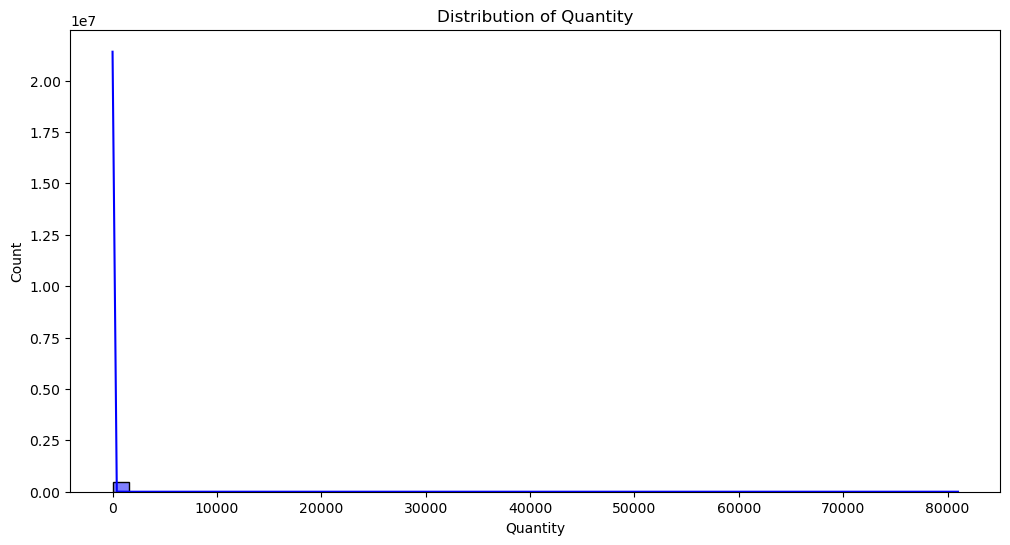

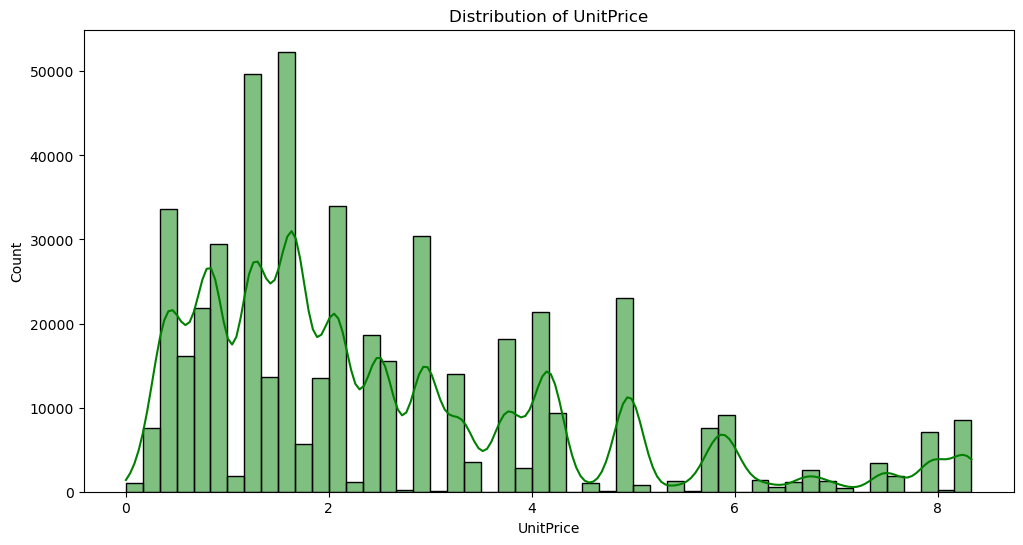

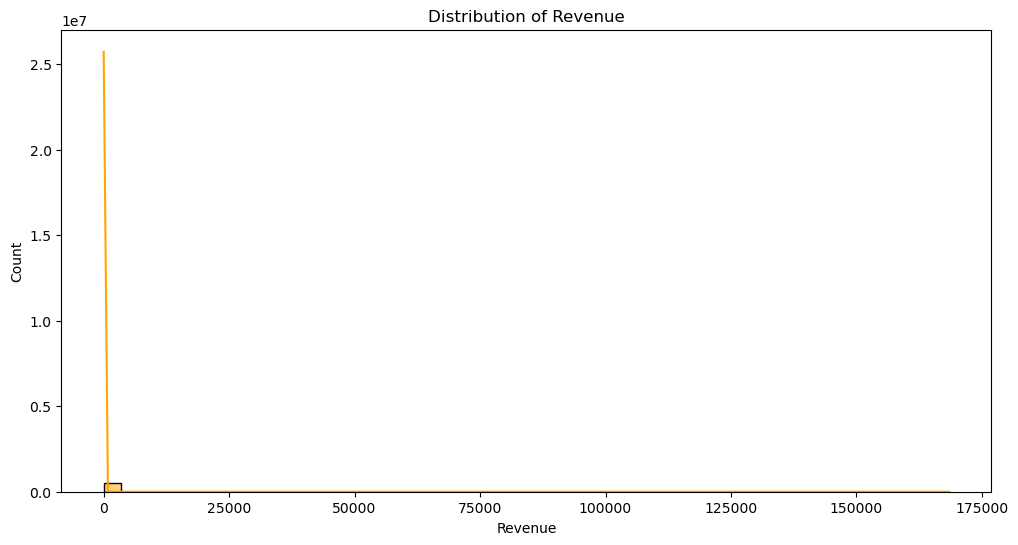

In [341]:
# Plotting the distribution of 'Quantity', 'UnitPrice' and 'Revenue' for future analysis
plt.figure(figsize = (12, 6))
sns.histplot(df_cleaned['Quantity'], kde = True, bins = 50, color = 'blue')
plt.title('Distribution of Quantity')
plt.show()

plt.figure(figsize = (12, 6))
sns.histplot(df_cleaned['UnitPrice'], kde = True, bins = 50, color = 'green')
plt.title('Distribution of UnitPrice')
plt.show()

plt.figure(figsize = (12, 6))
sns.histplot(df_cleaned['Revenue'], kde = True, bins = 50, color = 'orange')
plt.title('Distribution of Revenue')
plt.show()


In [342]:
# Normalizing the 'Quantity' and 'Revenue' features
df_cleaned['Log_Quantity'] = np.log1p(df_cleaned['Quantity'])
df_cleaned['Log_Revenue'] = np.log1p(df_cleaned['Revenue'])

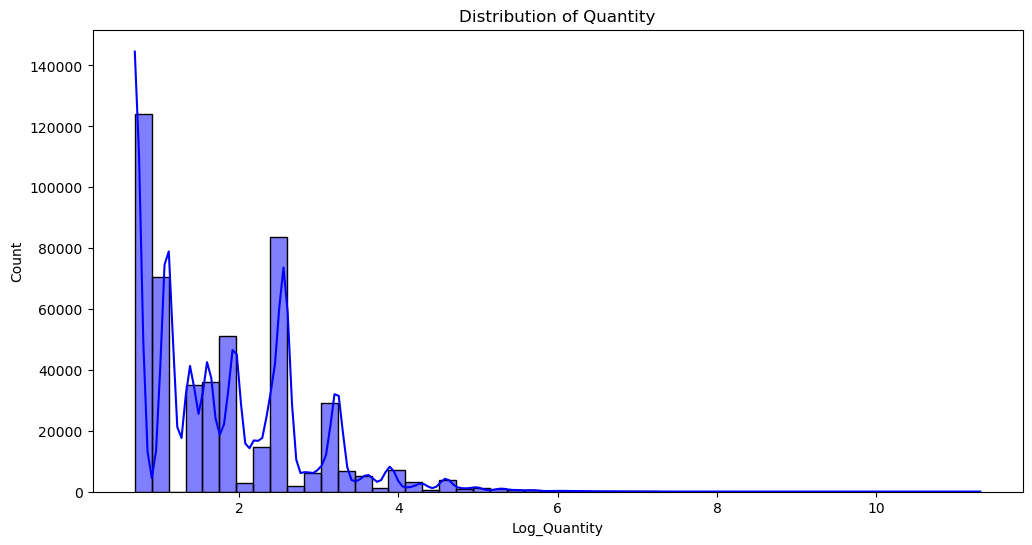

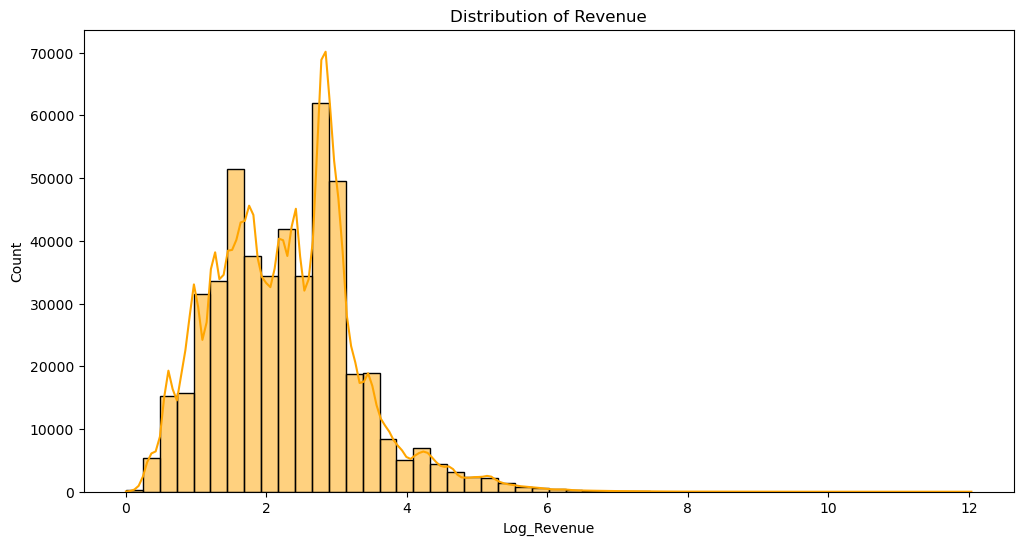

In [343]:
# Plotting the distribution of 'Quantity' and 'Revenue' after the normalization
plt.figure(figsize = (12, 6))
sns.histplot(df_cleaned['Log_Quantity'], kde = True, bins = 50, color = 'blue')
plt.title('Distribution of Quantity')
plt.show()

plt.figure(figsize = (12, 6))
sns.histplot(df_cleaned['Log_Revenue'], kde = True, bins = 50, color = 'orange')
plt.title('Distribution of Revenue')
plt.show()


#### Insight
After plotting the distribution of the 'Quantity', 'UnitPrice' and 'Revenue' features, as it can seen above, it was noteced that 'Quantity' and 'Revenue' conteined a very skewed distribution, as it is showed in the above plot, the long tail in the right side of it. Skewed data can dominate a model training, thus to avoid such thing, log transformation was applied on these features, reducing variances, making large outliers less influential, and putting data closer to a normal distribution that will be ideal for future aplication of foricasting technique.

In [344]:
# Saving the clean dataset to a file
df_cleaned.to_csv('cleaned_online_retail.csv', index = False)

## Exploratory Data Analysis (EDA)

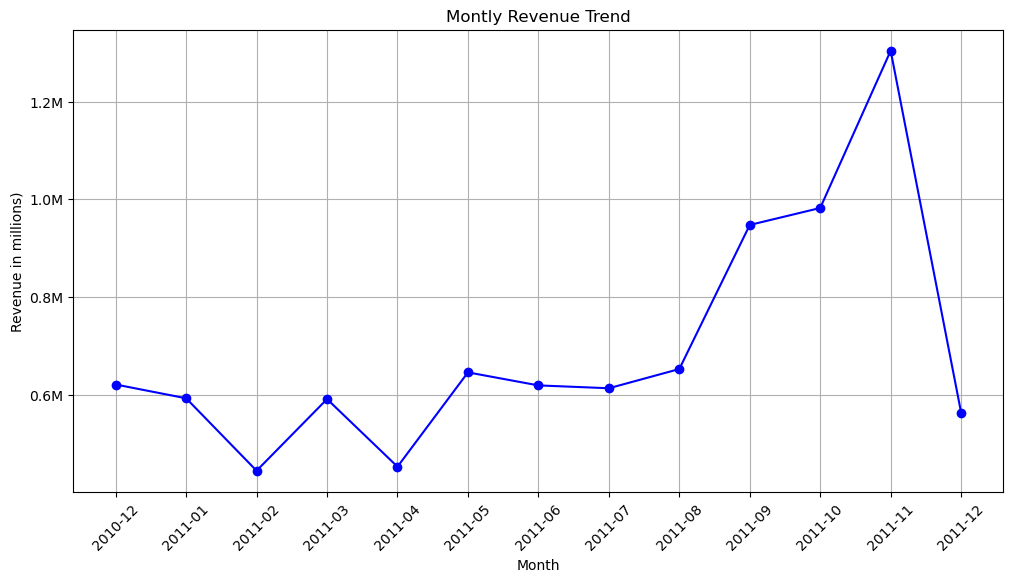

In [345]:
# Agragate sales revenue by month in 2011
df_monthly = df_cleaned.groupby(df_cleaned['InvoiceDate'].dt.to_period('M'))['Revenue'].sum()

# Plotting the montly revenue trend
plt.figure(figsize = (12, 6))
plt.plot(df_monthly.index.astype(str),df_monthly, marker = 'o', linestyle = '-', color = 'blue')
plt.title('Montly Revenue Trend')
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))
plt.xlabel('Month')
plt.ylabel('Revenue in millions)')
plt.grid(True)
plt.xticks(rotation = 45)
plt.show()


#### Insight
As we can see above for the year of 2011, the online sales are down in the first semester and grows in the second, towards the end of the year and Christmas time, what makes its more interesting is that in November of 2011 the sales are way higher then Dezember, probably because of events like Black Friday wich can make people to by christmas presents earlier.

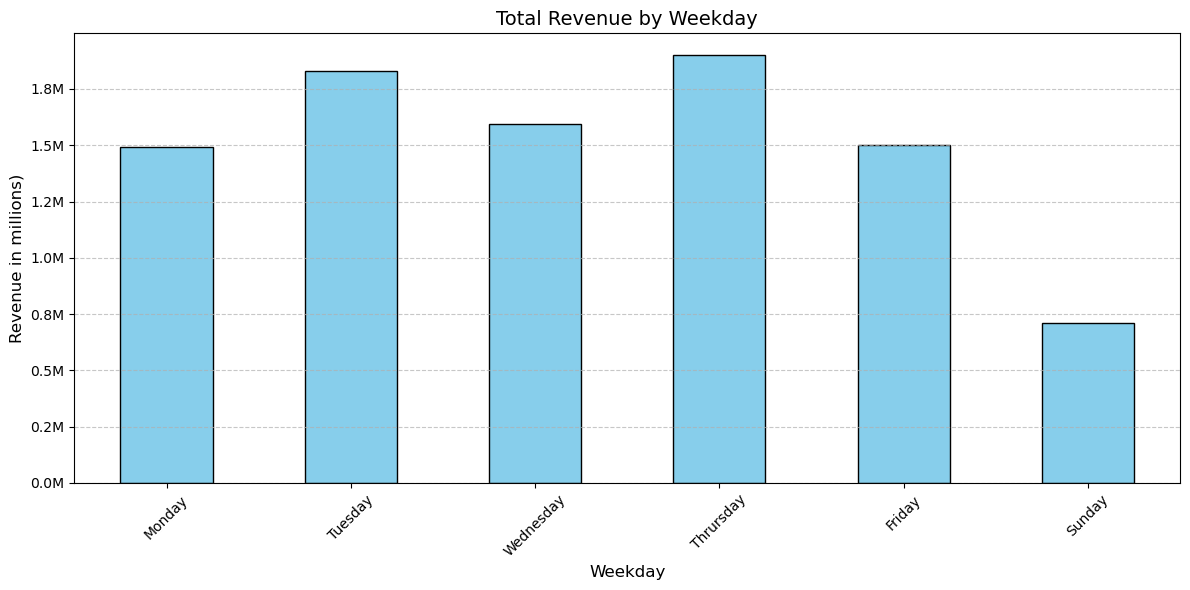

In [346]:
# Agragate sales revenue by weekday
df_weekday = df_cleaned.groupby(df_cleaned['Weekday'])['Revenue'].sum()

# Mapping weekdays
weekday_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thrursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df_weekday.index = df_weekday.index.map(weekday_mapping)

# Plotting the revenue trend by weekday
plt.figure(figsize = (12, 6))
df_weekday.plot(kind = 'bar', color = 'skyblue', edgecolor = 'black')
plt.title('Total Revenue by Weekday', fontsize = 14)
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))
plt.xlabel('Weekday', fontsize = 12)
plt.ylabel('Revenue in millions)', fontsize = 12)
plt.grid(axis = 'y', linestyle = ('--'), alpha = 0.7)
plt.xticks(rotation = 45, fontsize = 10)
plt.tight_layout()
plt.show()


#### Insight
As we can see on the graph above, Thrusday brings in the biggest revenues on online sales, followed by Tuesday. Sunday, on the other hand, generates the last amount of sales. This can suggests that weekdays patterns may have an impact on sales, maybe reflecting the purchasing habts of customers.

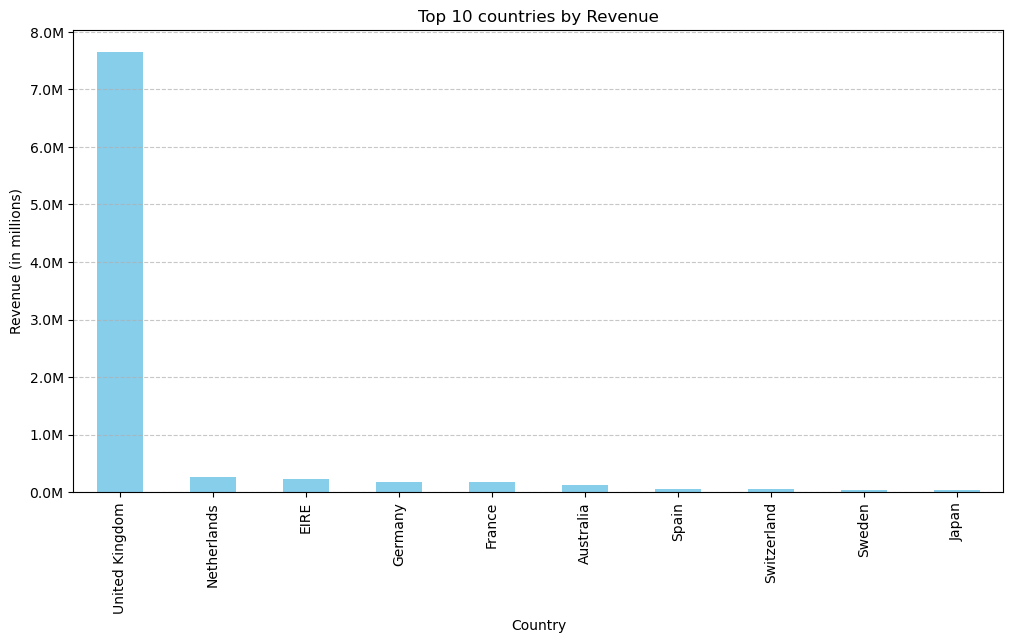

In [347]:
# Revenue by country on oline sales
revenue_country = df_cleaned.groupby('Country', observed = True)['Revenue'].sum().sort_values(ascending = False)
plt.figure(figsize = (12, 6))
revenue_country.head(10).plot(kind = 'bar', color = 'skyblue')
plt.title('Top 10 countries by Revenue')
plt.xlabel('Country')
plt.ylabel('Revenue (in millions)')
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.show()

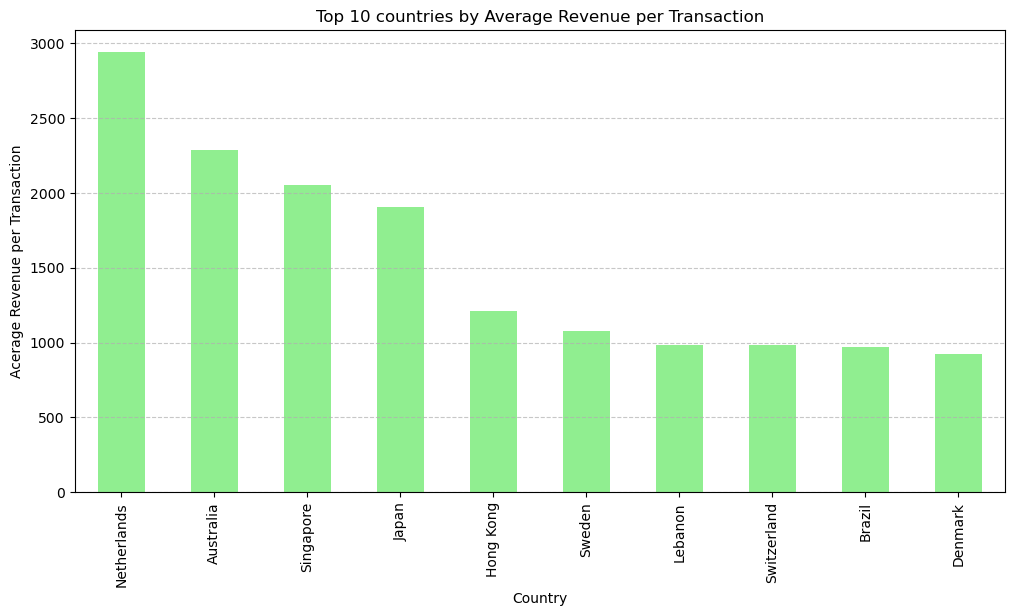

In [348]:
# Normalize revenue by calculating total revenue and transaction per country
country_stats = df_cleaned.groupby('Country', observed = True).agg(total_revenue = ('Revenue', 'sum'),
                                                  number_of_transactions = ('InvoiceNo', 'nunique'))
country_stats['revenue_per_transaction'] = country_stats['total_revenue'] / country_stats['number_of_transactions']

# Plotting
top_10_countries = country_stats.sort_values(by = 'revenue_per_transaction', ascending = False).head(10)
plt.figure(figsize = (12, 6))
top_10_countries['revenue_per_transaction'].plot(kind = 'bar', color = 'lightgreen')
plt.title('Top 10 countries by Average Revenue per Transaction')
plt.xlabel('Country')
plt.ylabel('Acerage Revenue per Transaction')
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.show()


#### Insight
In the first graph we can see that UK dominates teh revenue, significantly overshadowing the other countries as already expected as the dataset is from the UK based and registered non-store online retail, but it is interesting to note that when it get nomalized by the number of transactions per country, it is noted that countries such as Netherlands, Australia and Singapore generates higher revenue per transaction compared to the UK.

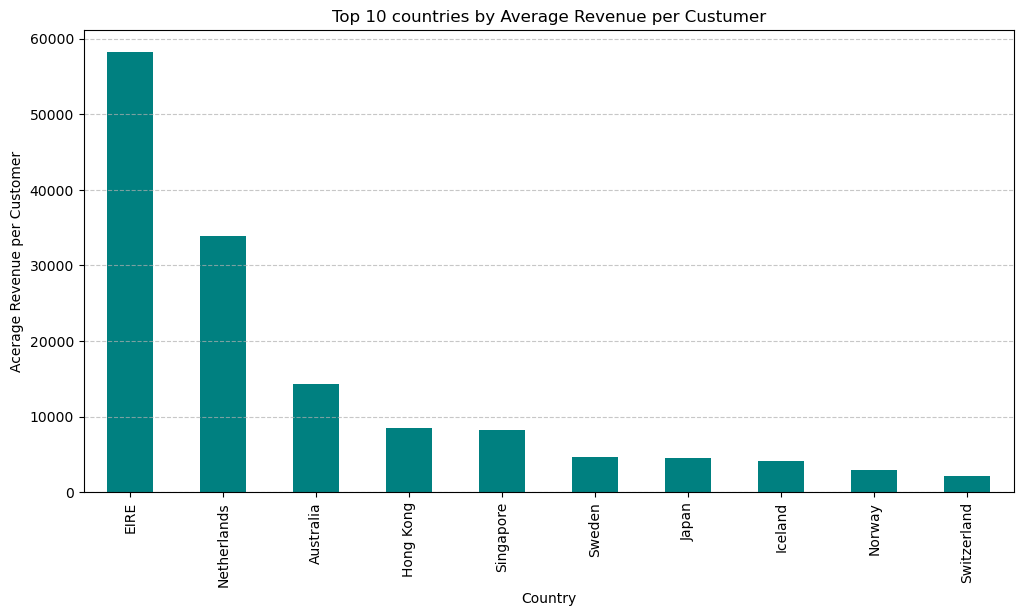

In [349]:
# Normalize revenue by calculating total revenue and transaction per country
country_customer_stats = df_cleaned.groupby('Country', observed = True).agg(total_revenue = ('Revenue', 'sum'),
                                                  number_of_customers = ('CustomerID', 'nunique'))

country_customer_stats['revenue_per_customer'] = country_customer_stats['total_revenue'] / country_customer_stats['number_of_customers']

# Plotting
country_customer_stats = country_customer_stats.sort_values(by = 'revenue_per_customer', ascending = False)
plt.figure(figsize = (12, 6))
country_customer_stats['revenue_per_customer'].head(10).plot(kind = 'bar', color = 'teal')
plt.title('Top 10 countries by Average Revenue per Custumer')
plt.xlabel('Country')
plt.ylabel('Acerage Revenue per Customer')
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.show()


#### Insight
Through the graph above, we can see that countries such as EIRE and Netherlands have a higher avarage revenue per customer compared to the others countries. It could help the bussiness to undestand and indentifying where to focus effots for customer retention or expansion.

CustomerID
14646    266194.22
18102    222135.17
17450    189848.73
16446    168472.50
14911    119677.40
12415    115158.98
14156     98526.73
17511     88118.52
12346     77183.60
16029     72368.49
Name: Revenue, dtype: float64


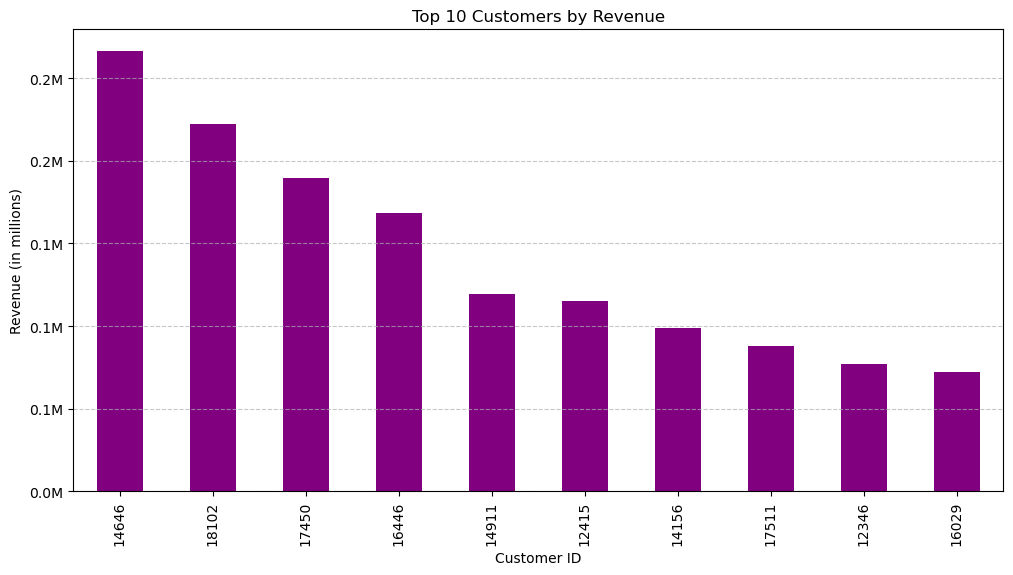

In [350]:
# Aggregate revenue by customer
customer_revenue = df_cleaned.groupby('CustomerID')['Revenue'].sum().sort_values(ascending = False)

# Excluding CustomerID == 0
customer_revenue = customer_revenue[customer_revenue.index != 0]

# Getting the top 10 customers
top_customers = customer_revenue.head(10)
print(top_customers)

# Plotting top customers by revenue
plt.figure(figsize = (12, 6))
top_customers.plot(kind = 'bar', color = 'purple')
plt.title('Top 10 Customers by Revenue')
plt.xlabel('Customer ID')
plt.ylabel('Revenue (in millions)')
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.show()

CustomerID
12346      1
12415     20
14156     52
14646     72
14911    197
16029     62
16446      2
17450     46
17511     31
18102     57
Name: InvoiceNo, dtype: int64


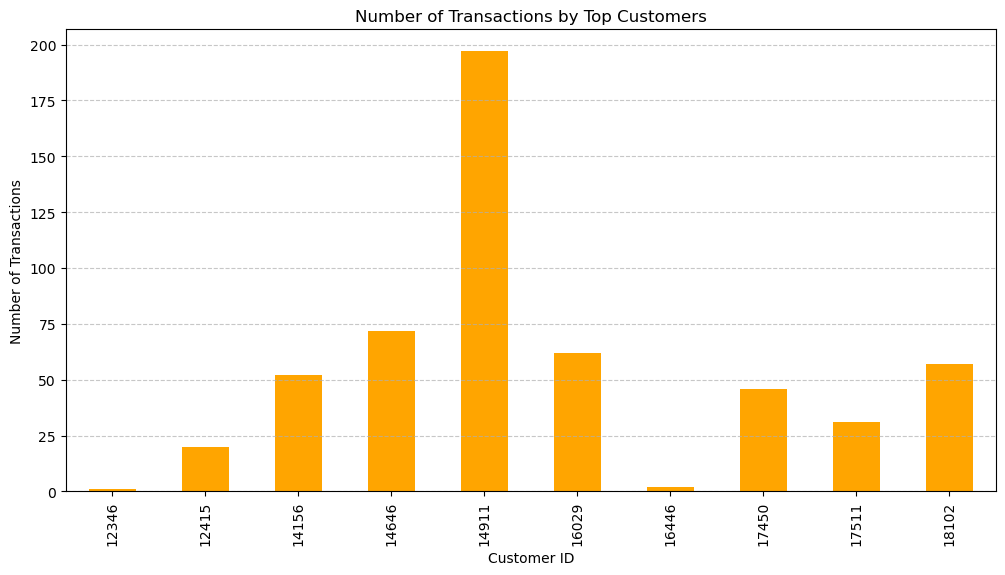

In [351]:
# Analyzing repeated purchases for top customers
top_customer_transaction = df_cleaned[df_cleaned['CustomerID'].isin(top_customers.index)]
repeat_purchases = top_customer_transaction.groupby('CustomerID')['InvoiceNo'].nunique()
print(repeat_purchases)

# Plotting
plt.figure(figsize = (12, 6))
repeat_purchases.plot(kind = 'bar', color = 'orange')
plt.title('Number of Transactions by Top Customers')
plt.xlabel('Customer ID')
plt.ylabel('Number of Transactions')
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.show()

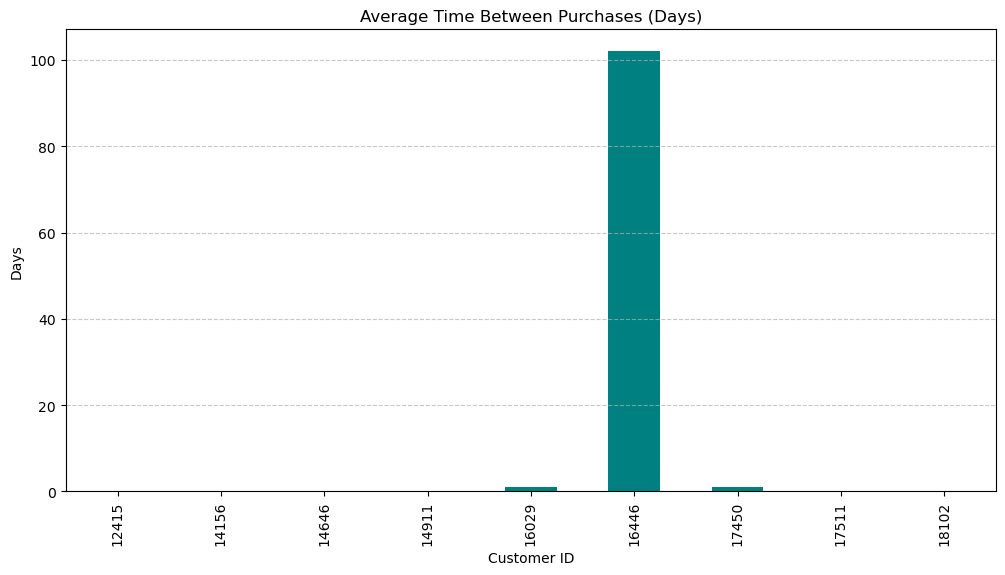

In [352]:
# Ensuring datatime format
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])

# Filtering top customers by revenue exclusing CustumerID == 0
top_customers = df_cleaned[df_cleaned['CustomerID'] != 0].groupby('CustomerID')['Revenue'].sum().nlargest(10).index
top_customer_transaction = df_cleaned[df_cleaned['CustomerID'].isin(top_customers)].copy()

# Calculating the average time between purchases for each top customer
time_between_purchases = (top_customer_transaction.groupby('CustomerID')['InvoiceDate']).apply(lambda x: x.sort_values().diff().mean())

# Eclusing NaT values (Custumers with only one transaction)
time_between_purchases = time_between_purchases.dropna()

# Plotting
plt.figure(figsize = (12, 6))
time_between_purchases.dt.days.plot(kind = 'bar', color = 'teal')
plt.title('Average Time Between Purchases (Days)')
plt.xlabel('Customer ID')
plt.ylabel('Days')
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.show()

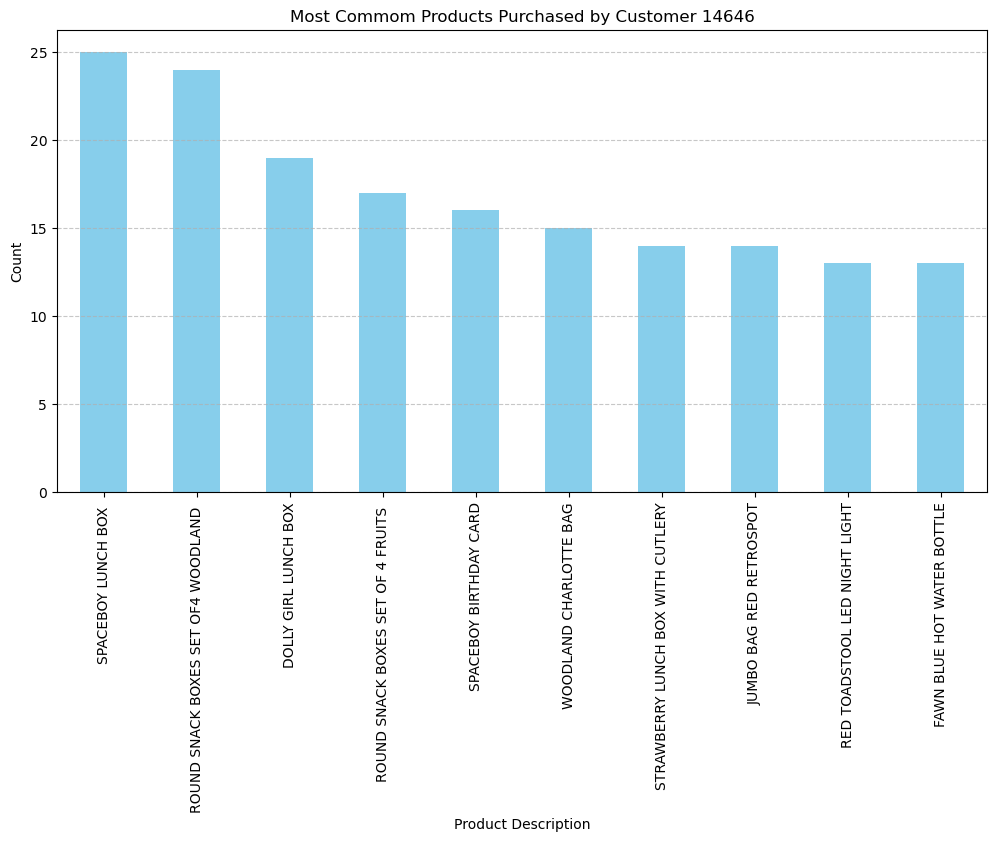

In [353]:
# Identifying the mot common products purchased by top customers
most_common_products = top_customer_transaction.groupby('CustomerID')['Description'].agg(lambda x: x.mode().iloc[0])

#Plotting for 1 customer
customer_id = top_customers[0]
customer_products = top_customer_transaction[top_customer_transaction['CustomerID'] == customer_id]
product_counts = customer_products['Description'].value_counts()

plt.figure(figsize = (12, 6))
product_counts.head(10).plot(kind = 'bar', color = 'skyblue')
plt.title(f'Most Commom Products Purchased by Customer {customer_id}')
plt.xlabel('Product Description')
plt.ylabel('Count')
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.show()

#### Insight
After analysing the top customers behavior, trying to undestand their tends and patterns, it is noted that the customer with ID 14646 contributes with the most revenue among the top 10 customers, indicating their significance to the business. The customer with ID 14911 is the one with the highest nimber of transactions among the top ones, it shows how engaged he id with the plataform, the customer with ID 16446 has a significantly longer average time between purchases, around 102 days, the bussinnes could set a remainder or even think about re-engagement campaings. We also can see that the customer ID 14646 has a specific kind of product that he always buys, being the 'Spaceboy Lunch Box" the most bought.

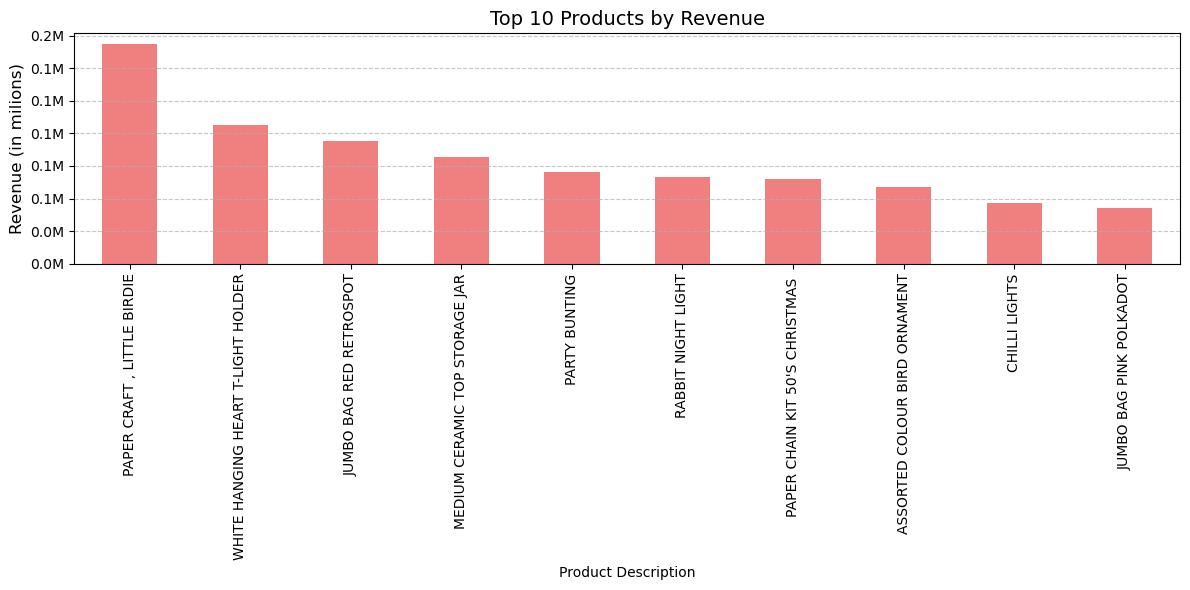

In [354]:
# Calculatinh total revenue per product
product_revenue = df_cleaned.groupby('Description', observed = True)['Revenue'].sum().sort_values(ascending = False)

# Plotting
plt.figure(figsize = (12, 6))
product_revenue.head(10).plot(kind = 'bar', color = 'lightcoral')
plt.title('Top 10 Products by Revenue', fontsize = 14)
plt.xlabel('Product Description')
plt.ylabel('Revenue (in milions)', fontsize = 12)
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.tight_layout()
plt.show()

Percentage contribution of top products to total renenue: 
 Description
PAPER CRAFT , LITTLE BIRDIE           1.866489
WHITE HANGING HEART T-LIGHT HOLDER    1.177006
JUMBO BAG RED RETROSPOT               1.043204
MEDIUM CERAMIC TOP STORAGE JAR        0.905171
PARTY BUNTING                         0.779622
RABBIT NIGHT LIGHT                    0.740859
PAPER CHAIN KIT 50'S CHRISTMAS        0.718762
ASSORTED COLOUR BIRD ORNAMENT         0.652864
CHILLI LIGHTS                         0.511843
JUMBO BAG PINK POLKADOT               0.469764
Name: Revenue, dtype: float64


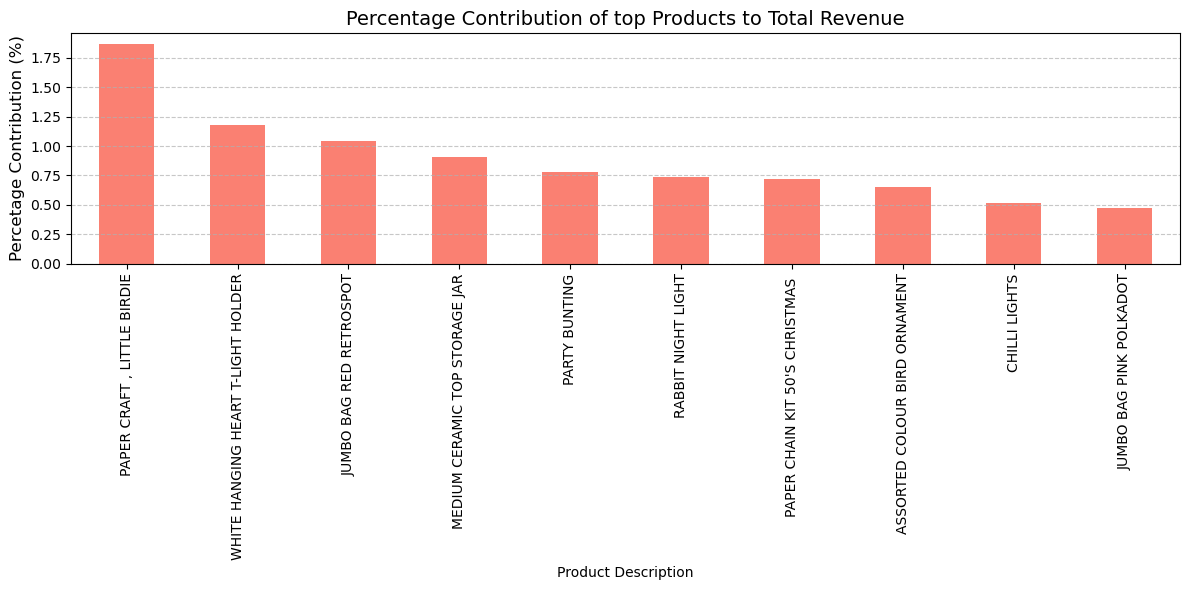

In [355]:
# Calculating percentage contribution of top products
product_revenue_percentage = (product_revenue.head(10) / product_revenue.sum()) * 100

# Printing results
print(f'Percentage contribution of top products to total renenue: \n {product_revenue_percentage}')

# Plotting
plt.figure(figsize = (12, 6))
product_revenue_percentage.plot(kind = 'bar', color = 'salmon')
plt.title('Percentage Contribution of top Products to Total Revenue', fontsize = 14)
plt.xlabel('Product Description')
plt.ylabel('Percetage Contribution (%)', fontsize = 12)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.tight_layout()
plt.show()



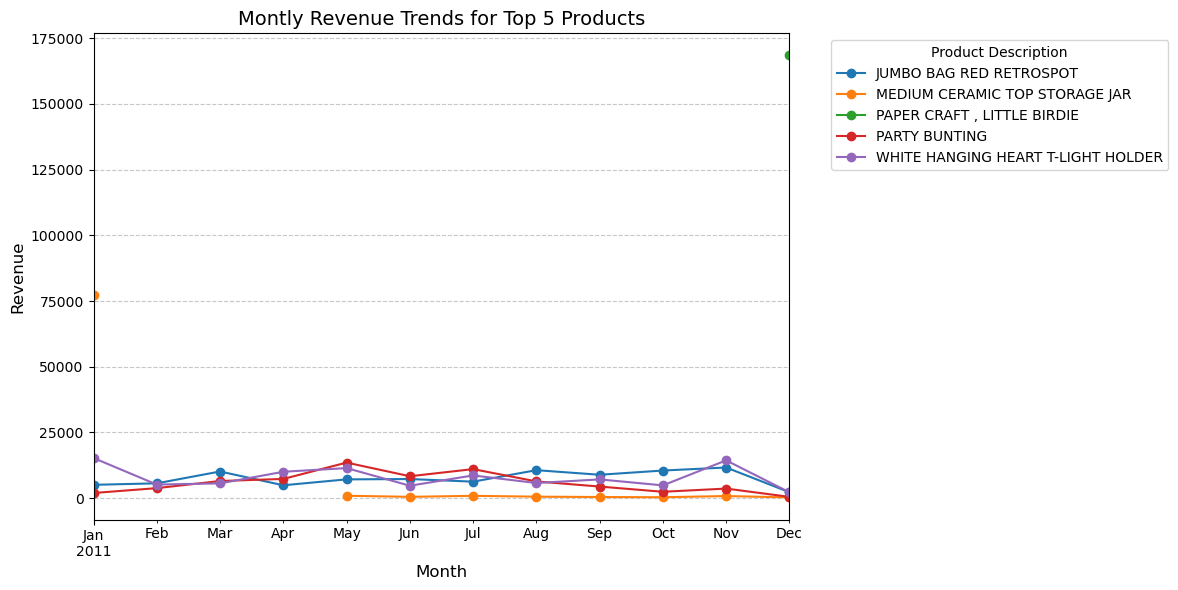

In [356]:
# Filtering for top 5 products
top_products = product_revenue.head(5).index
top_products_data = df_cleaned[df_cleaned['Description'].isin(top_products)].copy()

# Limiting the timeframe to be able to plot
top_products_data['YearMonth'] = top_products_data['InvoiceDate'].dt.to_period('M')
limited_timeframe = top_products_data[top_products_data['YearMonth'].dt.year == 2011]

# Grouping revenue by product and month
montly_revenue_top_products = top_products_data.groupby(['YearMonth', 'Description'], observed = True)['Revenue'].sum().unstack()

# Reducing data size for plotting 
limited_revenue = montly_revenue_top_products.loc['2011']

# Plotting 
limited_revenue.plot(kind = 'line', figsize = (12, 6), marker = 'o')
plt.title('Montly Revenue Trends for Top 5 Products', fontsize = 14)
plt.xlabel('Month', fontsize = 12)
plt.ylabel('Revenue', fontsize = 12)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.legend(title='Product Description', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Insight
Throght the products' revenue analysis we can see that the product 'Paper craft, litte brirdie' stands out as the top perfomer and it contributs more revenue then others. For the percentage contribution to total revenue we can note that the top 3 products contribute collectively more than 4% of the toral revenue. And for te monthly revenue trends it is possible to note that 'Paper craft, litte brirdie' has a consistent contribution across months.

In [357]:
# Preparing the data for Time-Series Analysis

# Setting the index
df_cleaned.set_index('InvoiceDate', inplace = True)
df_cleaned.sort_index(inplace = True)


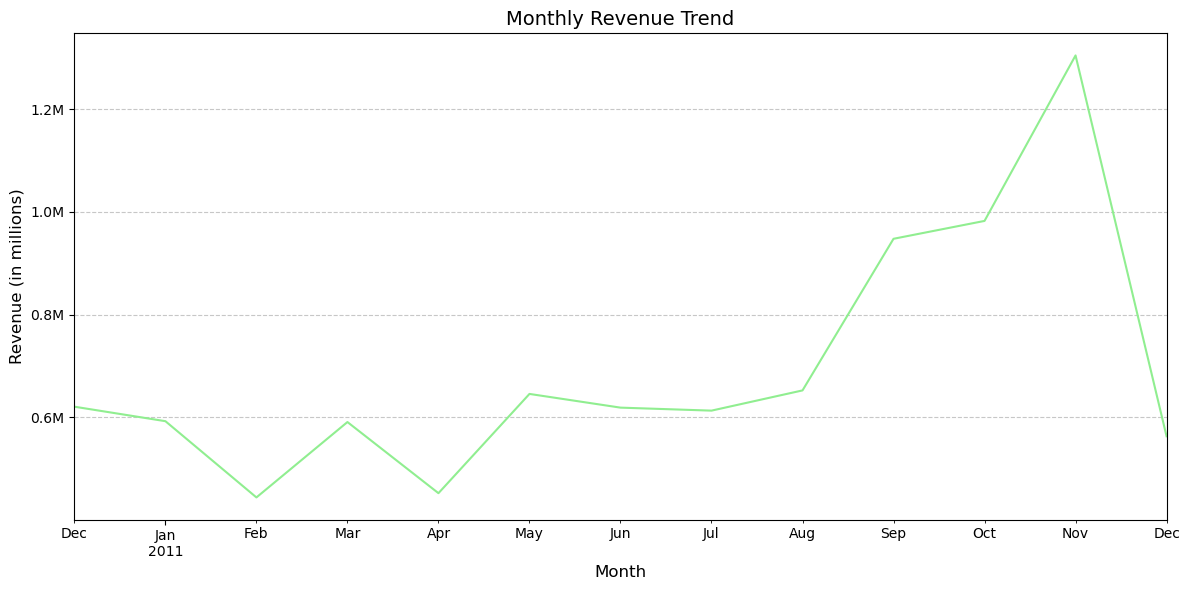

In [358]:
# Groupping by month for a cleaner trend analysis
monthly_revenue = df_cleaned['Revenue'].resample('ME').sum()

# Plotting
monthly_revenue.plot(figsize = (12, 6), color = 'lightgreen')
plt.title('Monthly Revenue Trend', fontsize = 14)
plt.xlabel('Month', fontsize = 12)
plt.ylabel('Revenue (in millions)', fontsize = 12)
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.tight_layout()
plt.show()

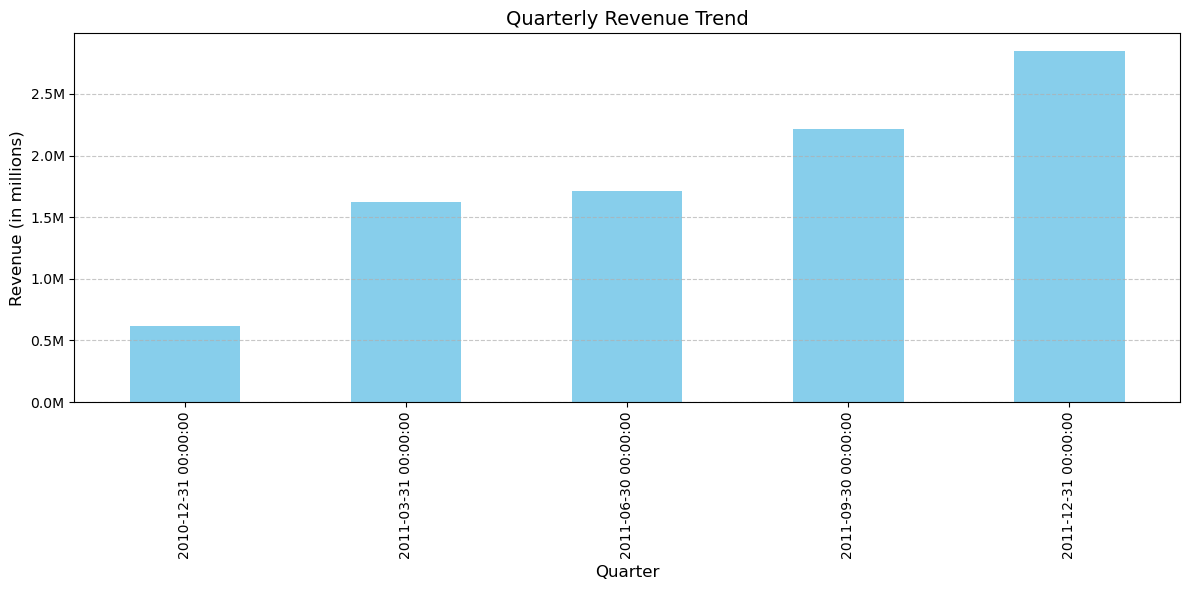

In [359]:
# Comparing quarters performance
quarterly_revenue = df_cleaned['Revenue'].resample('QE').sum()

# Plotting
quarterly_revenue.plot(kind = 'bar', figsize = (12, 6), color = 'skyblue')
plt.title('Quarterly Revenue Trend', fontsize = 14)
plt.xlabel('Quarter', fontsize = 12)
plt.ylabel('Revenue (in millions)', fontsize = 12)
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.tight_layout()
plt.show()

#### Insight
As we can see, the fourth quarter is the stronger one, with more sales, monstly because of the rolidays, but even thought December has the Christmas time, November, probably because sales events such as Black Friday is the one with the most revenue.

## Time-Series and Forecasting

In [360]:
# Testing Statistical Significance
# Spliting data by quarters
df_cleaned['Quarter'] = df_cleaned.index.quarter
revenue_by_quarter = df_cleaned.groupby('Quarter')['Revenue'].sum()
print(revenue_by_quarter)

Quarter
1    1627009.050
2    1716394.811
3    2212578.853
4    3470034.470
Name: Revenue, dtype: float64


In [361]:
# Producing a ANOVA test
q1_revenue = df_cleaned[df_cleaned['Quarter'] == 1] ['Revenue']
q2_revenue = df_cleaned[df_cleaned['Quarter'] == 2] ['Revenue']
q3_revenue = df_cleaned[df_cleaned['Quarter'] == 3] ['Revenue']
q4_revenue = df_cleaned[df_cleaned['Quarter'] == 4] ['Revenue']

f_start, p_value = f_oneway(q1_revenue, q2_revenue, q3_revenue, q4_revenue)
print(f'F-statistic: {f_start}, p-value: {p_value}')

F-statistic: 0.5913339926762042, p-value: 0.620608980148067


#### Insight
As we can see throught the ANOVA test, the difference between the quarters are not statistically significant, the p-value is much geater then teh common threshild of 0.05 or 5% significance level meaning that there is no strong evidence to reject the null hypothesis. The null hypothesis assumes that the means of groups are equal, since the p-value is high, the data doesn't provide sufficient evidence to claim that the revenue differs significantly between quarters. The ANOVA test is a statistical method used to compare the means of three or more group and determine if there is diferences between them.

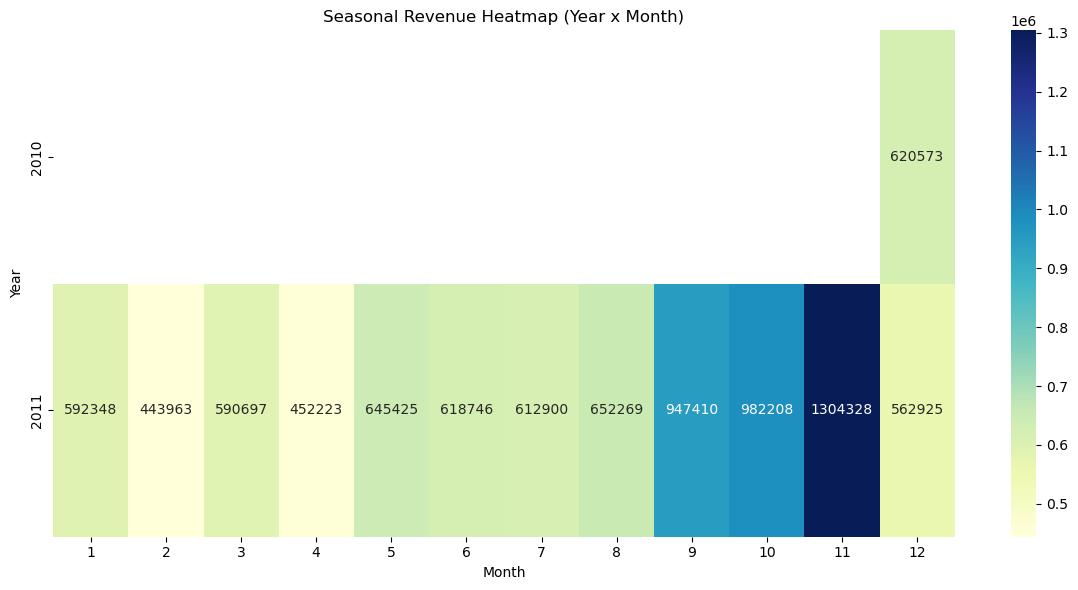

In [362]:
# Seasonal Heatmap

revenure_heatmap = df_cleaned.groupby([df_cleaned.index.year, df_cleaned.index.month])['Revenue'].sum().unstack()

# Plotting
plt.figure(figsize = (12, 6))
sns.heatmap(revenure_heatmap, cmap = 'YlGnBu', annot = True, fmt = '.0f')
plt.title('Seasonal Revenue Heatmap (Year x Month)')
plt.xlabel('Month')
plt.ylabel('Year')
plt.tight_layout()
plt.show()

#### Insight
The heatmap above was created to visualize the seasonal revenue patterns over 13 month helping on identifing the peak and low periods. Thought this heatmap of the revenue by month, we can note the gradual builup to the peak season, the steady growing of the revenue starting from august abd September leading to November indicates a preparation for the holiday season.

In [363]:
# ARIMA model for forecasting
model = ARIMA(monthly_revenue, order = (1, 1, 1))
model_fit = model.fit()
forecast = model_fit.forecast(steps = 3)
print(forecast)

2012-01-31    846037.365572
2012-02-29    830745.875450
2012-03-31    831571.802138
Freq: ME, Name: predicted_mean, dtype: float64


#### Insight
Even thought there is a limitation on the data as it only has 13 month to be anylized, it was applied the ARIMA model for foricasting and the values above represents the best the model's best estimates given the constrains od the dataset. The parameters used on this models is the p, d, and q, p is the number of the past value or lags the model uses to predict the current value, d stands for differencing order, 1 in that case means that the model calculates the difference between consecutives datapoints once and q means the moving average order, the number 1 mean that the model uses the last error to correct the current prediction.

In [364]:
# Validation of ARIMA Predictions
# Splitting the data in train and test
train_data = monthly_revenue[: '2011 - 09']
test_data = monthly_revenue['2011 - 10' :]

# Fit ARIMA model
model = ARIMA(train_data, order = (1, 1, 1))
fitted_model = model.fit()

# Generating predictions for the test period
forecast  = fitted_model.forecast(steps = len(test_data))

# Comparing prediction with actual values
print(f'Predictions: \n {forecast}')
print(f'Actual Value: \n {test_data.values}')

Predictions: 
 2011-10-31    972259.844850
2011-11-30    949948.954678
2011-12-31    969980.454646
Freq: ME, Name: predicted_mean, dtype: float64
Actual Value: 
 [ 982207.97 1304327.61  562925.47]


In [365]:
# Calcuating error metrics
mape = mean_absolute_percentage_error(test_data.values, forecast)
rmse = np.sqrt(mean_squared_error(test_data.values, forecast))

# Printing
print(f'MAPE: {mape * 100: .2f}%')
print(f'RMSE: {rmse}')

MAPE:  33.50%
RMSE: 311649.88746316003


#### Insight
To confirm teh performance od the ARIMA model, a validation was applied, using the evaluation metrics, Mean Absolute Percentage (MAPE) and Root Mean Squared Error (RMSE). MAPE works calculating the average percentage difference between the predicted and actual value as the RMSE measures the standard deviation of the prediction errors, giving more weight to larger errors. For this model the MAPE was 33.50%, indicating that the average prediction error is about to one-third of the actual revenue and the RMSE was 311,649.88, reflecting the average deviation of the predictions from the actual values.

In [366]:
# Preparing the dataset to implement phophet model
df_prophet = monthly_revenue.reset_index()
df_prophet.columns = ['ds', 'y']

In [367]:
# Initializing the model
model = Prophet()

# Fitting the model
model.fit(df_prophet)

12:01:39 - cmdstanpy - INFO - Chain [1] start processing
12:01:39 - cmdstanpy - INFO - Chain [1] done processing


In [368]:
# Creating a dataframe for future dates
future = model.make_future_dataframe(periods = 3, freq = 'ME')

# Generating predictions
forecast = model.predict(future)

# Displaying forecasted values
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
11,2011-11-30,8.815273e+05,642510.303268,1.113460e+06
12,2011-12-31,9.196579e+05,692978.813520,1.170226e+06
13,2012-01-31,9.577885e+05,716785.776445,1.203315e+06
14,2012-02-29,9.934591e+05,751142.073710,1.242906e+06
15,2012-03-31,1.031590e+06,788270.499302,1.279729e+06


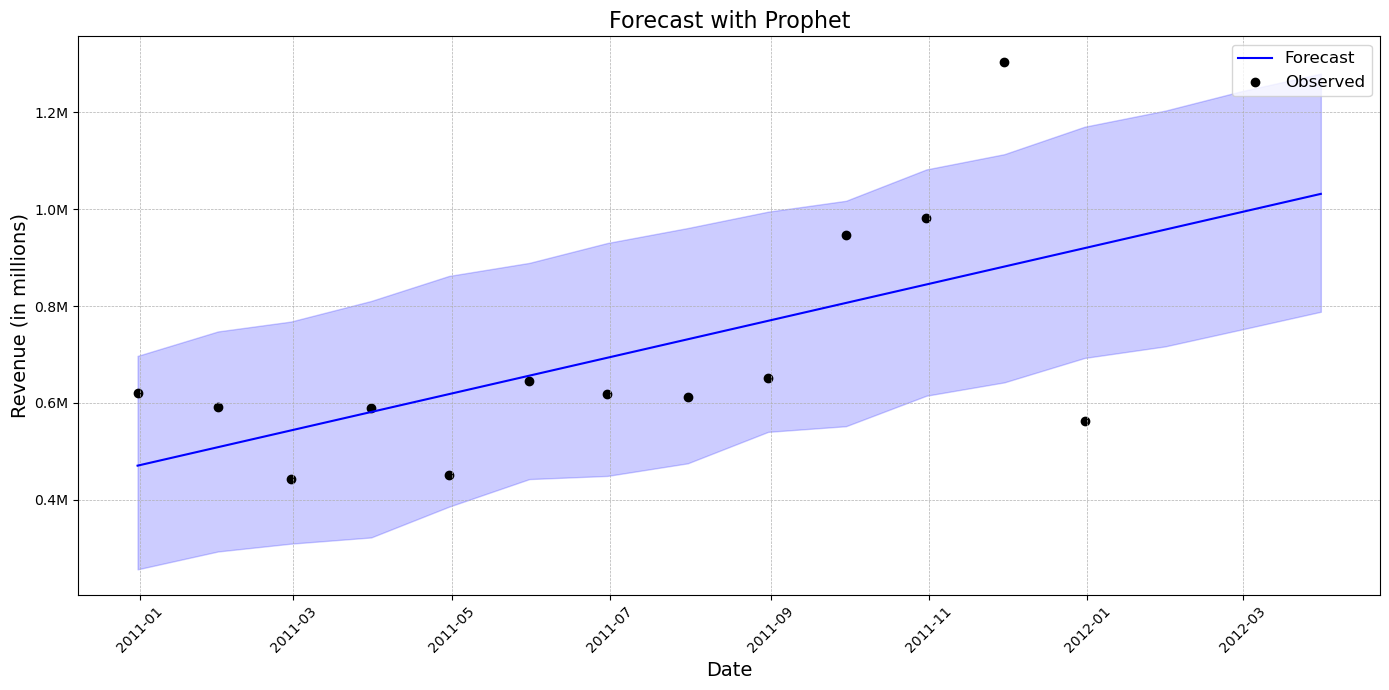

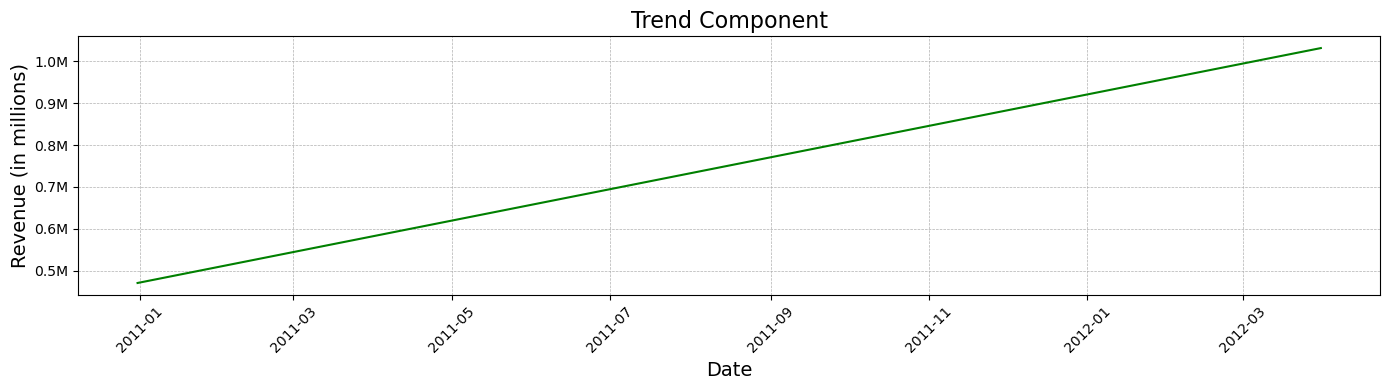

In [369]:
# Visualizing the forecast
plt.figure(figsize=(14, 7))
plt.plot(forecast['ds'], forecast['yhat'], label = 'Forecast', color ='blue')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=0.2)
plt.scatter(model.history['ds'], model.history['y'], label = 'Observed', color = 'black')
plt.title('Forecast with Prophet', fontsize = 16)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Revenue (in millions)', fontsize = 14)
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))
plt.grid(axis='both', linestyle = '--', linewidth = 0.5)
plt.legend(fontsize = 12)
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

# Visualizing trend and seasonality components
plt.figure(figsize=(14, 4))
plt.plot(forecast['ds'], forecast['trend'], label = 'Trend', color = 'green')
plt.title('Trend Component', fontsize = 16)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Revenue (in millions)', fontsize = 14)
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))
plt.grid(axis='both', linestyle = '--', linewidth = 0.5)
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

In [370]:
# Filtering predictions for the actual test period
test_predictions = forecast[forecast['ds'].isin(test_data.index)]
mape = mean_absolute_percentage_error(test_data.values, test_predictions['yhat'])
rmse = np.sqrt(mean_squared_error(test_data.values, test_predictions['yhat']))

# Printing metrics
print(f"MAPE: {mape * 100:.2f}%")
print(f"RMSE: {rmse}")

MAPE: 36.60%
RMSE: 329113.3337171881


#### Insight
Throught its metrics results, which was MAPE of 36.60% and an RMSE of 329,113, we can see that the accurancy of the Prophete model was moderate. The increased trend in revenue over the time period of the dataset was successfully represented by the model. The confidence intervals (shared region) shows how well the forecasts match the dataset's observed values within a reasonable range of uncertanty. Prophet's capacity to breack down and extrapolate trends may have been limited by the dataset's brief duration of 13 months, the dataset's propertiies could have been better served by ARIMA's dependence on past trends.

For this dataset, the ARIMA model performed slightly better than Prophet in terms of MAPE(33.50%) and RMSE(311,649). However, when it came to capturing trends and seasonality, both models displayed comparable advantages and disadvantages. Prophet is useful in situations that call for a quick prototyping and interpretability(such as predicting seasonal sales for a business planning), as ARIMA is still a viable option for accurate forecasting of particular datasets with stable properties.

## Conclusion

In this project, the Online Retail Dataset was explored to discover trends in its revenue, custumer behavior and product performance. It was also developed a preditive model to forecast revenue. A lot was leaned from the dataset and how it represents businedd dynamics by integrating time-series modeling with exploratory data analysis (EDA).

Key Findings
In revenue trends, seasonal variations were erident in monthly and quarterly revenue trends with holiday-related peaks, custumer analysis, actionable insights into customer tactics were obtained by indentifying high-value custumers and their puchases patterns and in product performance, opportunities for marketing campaings and inventory prioritization were identified through analysis of top performing products.

Challenges Faced
Since the dataset only covers 13 months, it is was challenging to identify long-term seasonal patterns, for accurance findings, many forecasting models, such as ARIMA and Prophet, need more data. Missing values needed to be handled carefully, especially in customer IDS, although this was addressed, bias can occasionally be introdjuced through inputation, furthermore, although ARIMA and Prophet performed rather well, they had trouble forecasting direct seasonal rise, like those that occurred in November and December. The error measures made through MAPE and RMSE indicates that while the predictions were accurate, they could yet be improved. In addition, external elements such as client demographics, promotional events, and economic situations were not included in the dataset, which could have improved the study and foricasting. Despite of the limitations that it has, this project has a useful application such as  the knowledge of consumer behavior and product performance, which could guide and improve marketing plans as well as inventory management, also, revenue projections could be useful tool for implemanting objectives and allocating funds.

Conclusion
This project demontated how data can be used to identify retail patterns, forecast future sales, and assist companies in making better decisions. Despite of the restrictions of the dataset, it was possible to simulate seasonal patterns and produce income forecasts by using time-series analysis.

Even though the data's 13-month span, the application of ARIMA and Prophet for time-series modeling gave the project the basis for understanding the revenue trends and their seasonality. It demonstrates the usefulness of time-series analysis in practical settings including budget allocation, inventory planning, and demand forecasting. The potential for time-series techniques to reveal patterns and produce accurate forecasts can be increased with the amount of data of the dataset.

Finally time-series technique can be a vital tool for businesses trying to forecast future trends and make proactive adjustmens. Building on the projects findings. such as refining the dataset and employing advanced models such as SARIMAX or LSTM networks, could significantly expand the range of the time-series applications and impruve even more precise and have more practical outomes.


